# SVHN Grayscale CNN MODEL



## 0) Import Libraries

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import mixed_precision

print("TensorFlow:", tf.__version__)

# ---- GPU (Metal) detection ----
gpus = tf.config.list_physical_devices("GPU")
print("GPU devices:", gpus)
print("All devices:", tf.config.list_physical_devices())

# Enable memory growth (recommended)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU detected + memory growth enabled.")
    except Exception as e:
        print("⚠️ Could not set memory growth:", e)
else:
    print("⚠️ No GPU detected — training will use CPU.")

# ---- CRITICAL FIX: Force float32 globally ----
# This avoids the situation where a previous mixed-precision policy causes training to get stuck at ~0.10 accuracy.
mixed_precision.set_global_policy("float32")
print("Precision policy:", mixed_precision.global_policy())


TensorFlow: 2.16.2
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU detected + memory growth enabled.
Precision policy: <DTypePolicy "float32">


## 1) Load dataset 

In [2]:
PATH = "SVHN_single_grey1.h5"  # keep .ipynb and .h5 in same folder
assert os.path.exists(PATH), f"File not found: {PATH}"

with h5py.File(PATH, "r") as f:
    X_train = np.array(f["X_train"])
    y_train = np.array(f["y_train"]).squeeze()
    X_val   = np.array(f["X_val"])
    y_val   = np.array(f["y_val"]).squeeze()
    X_test  = np.array(f["X_test"])
    y_test  = np.array(f["y_test"]).squeeze()

print("Raw shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

print("Unique y_train:", np.unique(y_train))
print("Unique y_val  :", np.unique(y_val))
print("Unique y_test :", np.unique(y_test))

# If your dataset ever has label 10 meaning digit 0 (classic SVHN quirk), uncomment below:
# y_train = y_train.copy(); y_val = y_val.copy(); y_test = y_test.copy()
# y_train[y_train == 10] = 0
# y_val[y_val == 10] = 0
# y_test[y_test == 10] = 0
# print("After SVHN 10→0 fix, unique y_train:", np.unique(y_train))


Raw shapes:
X_train: (42000, 32, 32) y_train: (42000,)
X_val  : (60000, 32, 32) y_val  : (60000,)
X_test : (18000, 32, 32) y_test : (18000,)
Unique y_train: [0 1 2 3 4 5 6 7 8 9]
Unique y_val  : [0 1 2 3 4 5 6 7 8 9]
Unique y_test : [0 1 2 3 4 5 6 7 8 9]


## 2) Preprocess 

In [3]:
X_train = (X_train.astype("float32") / 255.0)[..., None]
X_val   = (X_val.astype("float32") / 255.0)[..., None]
X_test  = (X_test.astype("float32") / 255.0)[..., None]

y_train = y_train.astype("int64")
y_val   = y_val.astype("int64")
y_test  = y_test.astype("int64")

print("Processed shapes:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


Processed shapes:
X_train: (42000, 32, 32, 1) X_val: (60000, 32, 32, 1) X_test: (18000, 32, 32, 1)


## 3) Visualize samples

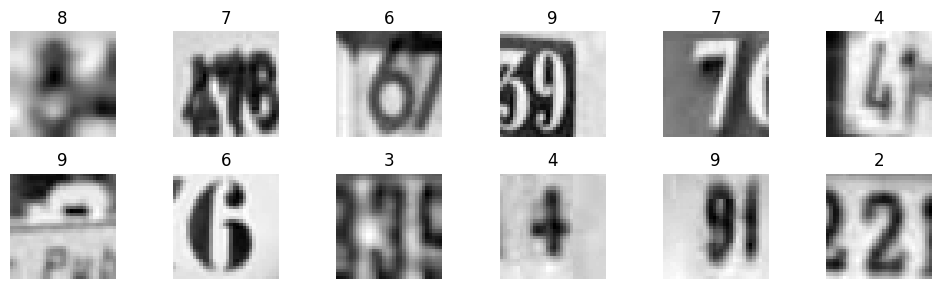

In [4]:
rng = np.random.default_rng(0)
idx = rng.choice(len(X_train), size=12, replace=False)

plt.figure(figsize=(10, 3))
for i, j in enumerate(idx, 1):
    plt.subplot(2, 6, i)
    plt.imshow(X_train[j].squeeze(), cmap="gray")
    plt.title(str(y_train[j]))
    plt.axis("off")
plt.tight_layout()
plt.show()


## 4) Data augmentation (accuracy boost)

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(0.10, 0.10),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomContrast(0.10),
], name="augmentation")

data_augmentation


2026-02-01 18:30:51.041379: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-02-01 18:30:51.041409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-01 18:30:51.041420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-01 18:30:51.041452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-01 18:30:51.041460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Sequential name=augmentation, built=False>

## 5) CNN (BatchNorm + LeakyReLU)

In [6]:
def make_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 1))
    x = data_augmentation(inputs)

    def block(x, filters):
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.1)(x)

        x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.1)(x)

        x = tf.keras.layers.MaxPool2D()(x)
        x = tf.keras.layers.Dropout(0.25)(x)
        return x

    x = block(x, 32)
    x = block(x, 64)
    x = block(x, 128)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = tf.keras.layers.Dropout(0.40)(x)

    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = make_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 324,138 (1.24 MB)

 Trainable params: 322,730 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

## 6) Compile (AdamW + optional label smoothing)

In [7]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)

loss_fn = "sparse_categorical_crossentropy"

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)


## 7) Train (batch_size = 256)

In [8]:
BATCH_SIZE = 256
EPOCHS = 40

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("best_svhn_cnn_upgraded.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40


2026-02-01 18:30:52.870575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.1464 - loss: 2.4616 - val_accuracy: 0.1301 - val_loss: 2.3801 - learning_rate: 3.0000e-04
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.3026 - loss: 1.9962 - val_accuracy: 0.1450 - val_loss: 3.0609 - learning_rate: 3.0000e-04
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.4901 - loss: 1.4715 - val_accuracy: 0.5718 - val_loss: 1.2559 - learning_rate: 3.0000e-04
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.6256 - loss: 1.1026 - val_accuracy: 0.7690 - val_loss: 0.7025 - learning_rate: 3.0000e-04
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.7088 - loss: 0.8788 - val_accuracy: 0.8328 - val_loss: 0.5264 - learning_rate: 3.0000e-04
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.7565 - loss: 0.7521 - val_accuracy: 0.8740 - val_loss: 0.4036 - learning_rate: 3.0000e-04
Epoch 7/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - 

## 8) Plot training curves

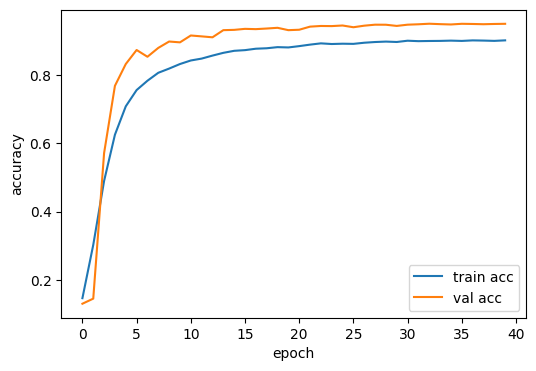

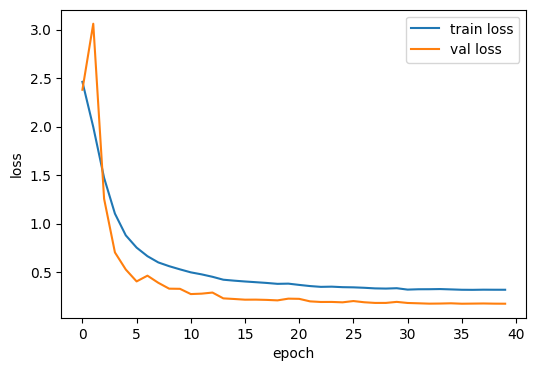

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


## 9) Evaluate on test set

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", test_acc)
print("Test loss    :", test_loss)


Test accuracy: 0.9453333616256714
Test loss    : 0.19378478825092316


## 10) Confusion matrix 

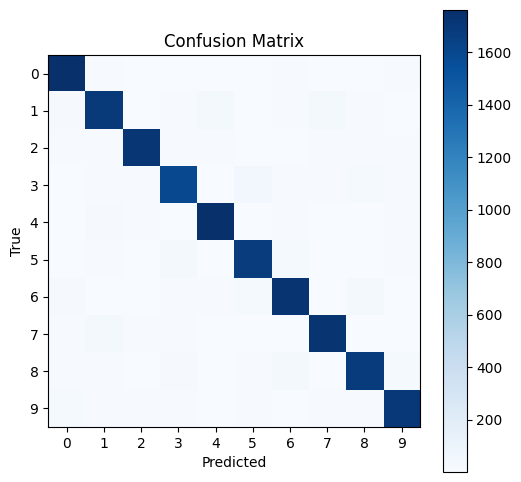

Per-class accuracy:
0: 0.970
1: 0.926
2: 0.952
3: 0.925
4: 0.965
5: 0.947
6: 0.942
7: 0.955
8: 0.928
9: 0.943


In [11]:
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = tf.math.confusion_matrix(y_test, pred, num_classes=10).numpy()

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

print("Per-class accuracy:")
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
for i, a in enumerate(per_class_acc):
    print(f"{i}: {a:.3f}")


In [12]:
best_model = tf.keras.models.load_model("best_svhn_cnn_upgraded.keras")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("✅ Best model test accuracy:", test_acc)

✅ Best model test accuracy: 0.9453333616256714


In [13]:
results = {
    "tf_version": tf.__version__,
    "batch_size": BATCH_SIZE,
    "epochs_ran": len(history.history["loss"]),
    "best_val_acc": float(np.max(history.history["val_accuracy"])),
    "final_train_acc": float(history.history["accuracy"][-1]),
    "test_acc": float(test_acc),
}
results

{'tf_version': '2.16.2',
 'batch_size': 256,
 'epochs_ran': 40,
 'best_val_acc': 0.9510499835014343,
 'final_train_acc': 0.9022619128227234,
 'test_acc': 0.9453333616256714}